# Сборный проект 

Анализ данных интернет-магазина «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

## Изучение данных из файла

В первую очередь необходимо изучить общую информацию о данных, чтобы проанализировать шаги, необходимые для этапа предобработки.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as st
from scipy import stats as st
import warnings
warnings.filterwarnings('ignore')

data = pd.read_csv('/datasets/games.csv')
#print(data.head(5))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [24]:
data_count = data.isna().sum().sort_values(ascending = False)
data_percent = (data_count /len(data))* 100
data_missing = pd.DataFrame([data_count, data_percent]).T
data_missing.columns =['number', 'percent']
data_missing.round(2)

,number,percent
Critic_Score,8578.0,51.32
Rating,6766.0,40.48
User_Score,6701.0,40.09
Year_of_Release,269.0,1.61
Genre,2.0,0.01
Name,2.0,0.01
Other_sales,0.0,0.00
JP_sales,0.0,0.00
EU_sales,0.0,0.00
NA_sales,0.0,0.00


### Вывод

Для анализа у нас есть данные, содержащие общую информацию о компьютерных играх и данные об их продажах до 2016 г. Среди недостатков набора данных можно отметить следующие:
 1. названия столбцов написаны с заглавной буквы, что сздает неоудобство для дальнейшей работы;
 2. имеются пропущенные значения: 51% данных, содержащих инфрмацию об оценках компьютерных игр критиками, пропущено, также пропуски есть в колонках, содержащих сведения об оценке игр пользователями(40.1%) и рейтинге игры (40.5%), а также года выпуска (1.6%);
 3. также некоторые столбцы имеет неправильный тип данных (например, год - текстовый тип).

## Предобработка данных

Первый шаг анализа - предобработка данных. В первую очередь для удобства восприятия необходимо привести к нижнему регистру названия столбцов.

In [25]:
data.columns = data.columns.str.lower()
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Проанализируем пропущенные значения: 
1. critic_score (50% пропущенных значений), user_score(40%), rating (40%)- несмотря на то, что процент пропущенных значений достаточно высок, восстановить эти данные не представляеся возможным, поскольку эти факторы субъективны и зависят только от мнения критиков/пользователей;
2. year_of_release имеет 1.6% пропущенных значений и также не требует восстановления - можно просто удалить эти строки;

Как можно увидеть, в столбце 'user_score' есть также аббревиатура 'tbd', которая расшифровывается как To Be Determined (будет определено) или To Be Decided (будет решено). Соответственно, этой аббревиатурой маркируются фильмы, рейтинг которых пока не определен. Именно поэтому данное значение мы будем причислять к пропущенным и заменим их на 'NaN'.

In [26]:
data['user_score'] = data['user_score'].replace('tbd', np.nan, regex=True)
data['user_score'] = data['user_score'].astype('float')
data['user_score']

0        8.0
1        NaN
2        8.3
3        8.0
4        NaN
        ... 
16710    NaN
16711    NaN
16712    NaN
16713    NaN
16714    NaN
Name: user_score, Length: 16715, dtype: float64

In [27]:
data.drop(data[data['year_of_release'].isna()].index, inplace=True)
data['year_of_release'] = data['year_of_release'].astype('int')
data['year_of_release']

0        2006
1        1985
2        2008
3        2009
4        1996
         ... 
16710    2016
16711    2006
16712    2016
16713    2003
16714    2016
Name: year_of_release, Length: 16446, dtype: int64

Кроме того, произведем необходимую замену данных: 'year_of_release' переведем из текстового типа в тип целого числа, 'user_score' из текстового типа - в вещественный тип. 

Следующим шагом рассчитаем суммарные продажи компьютерных игр во всех регионах.

In [28]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.head(5)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Вывод

В результате предобработки данных были проанализированы пропущенные значения, данные приведены к необходимым типам и произведен расчет данных о суммарных продажах компьютерных игр в регионах. 

## Исследовательский анализ данных

Следующий шаг работы - исследовательский анализ данных. В первую очередь проанализируем количество игр, которое выпускалось в разные годы. Как можно увидеть из графика, приведенного ниже, индустрия компьютерных игр начинает бурное развитие в период конца 90-х -начала 00-х гг., до этого периода рынок еще не был сформирован. Взлет индустрия передивает в 2000-2009 г., когда объемы выпуска игр достигают максимума. С начала 2010-х гг. развитие рынка имеет, скорее, снижающийся характер (даже с учетом того, что данные за 2016 г. у нас не в полном объеме). Соответственно, для решения поставленной задачи - прогноза на 2017 г. нас будут интересовать данные с 2012 г., так как именно к этому времени тренд роста сменяется некоторым спадом.

Text(0.5, 0, 'год')

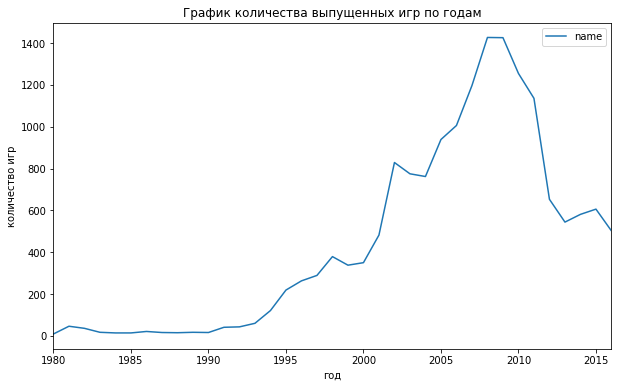

In [29]:
games_on_period = data.pivot_table(index='year_of_release', values='name', aggfunc='count').reset_index()
plt = games_on_period.plot(y = 'name', x = 'year_of_release', figsize = (10,6))
plt.set_title("График количества выпущенных игр по годам")
plt.set_ylabel('количество игр')
plt.set_xlabel('год')

Изучим изменения продаж компьютерных игр по платформам.

Text(0.5, 0, 'название платформы')

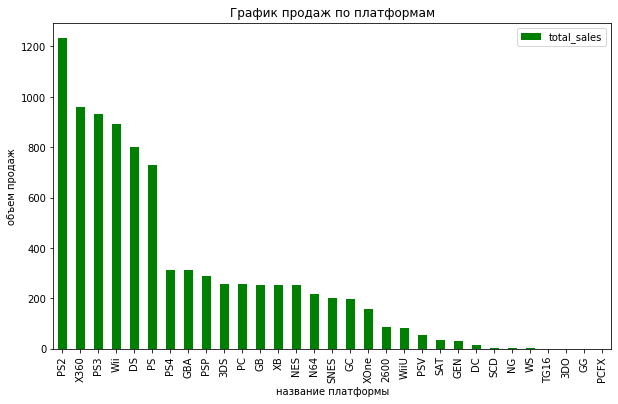

In [30]:
games_on_period = data.pivot_table(index='platform', values=['total_sales'], aggfunc='sum').sort_values(by = 'total_sales', ascending = False).reset_index()
plt = games_on_period.plot(y = 'total_sales', x = 'platform', kind = 'bar', figsize = (10,6), color = 'g')
plt.set_title("График продаж по платформам")
plt.set_ylabel('объем продаж')
plt.set_xlabel('название платформы')

Как видно из гистограммы, среди топ-5 платформ с наибольшими суммарными продажами можно выделить PS2, X360, PS3, Wii и  DS. Изучим их развитие подробнее.

In [9]:
leaders = data.query('platform == ["DS","PS2","PS3","Wii","X360"] and year_of_release >= 2000')

In [10]:
platform_data = leaders.groupby(['year_of_release', 'platform']).agg({'total_sales': 'sum'})

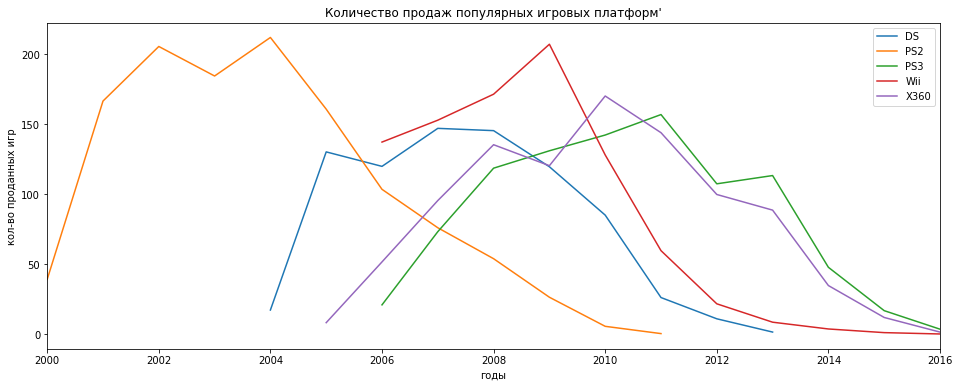

In [11]:
plot_platform = platform_data.pivot_table(index='year_of_release', columns='platform').plot(figsize = (16,6))
plot_platform.set_title("Количество продаж популярных игровых платформ'")
plot_platform.set_ylabel('кол-во проданных игр')
plot_platform.set_xlabel('годы') 
plot_platform.legend(labels = ['DS','PS2','PS3','Wii','X360']) 

Проанализировав распределение по годам продаж компьютерных игр платформами-лидерами, можно увидеть, что платформа в среднем "живет" около 10 лет.

Как было уже сказано ранее, актуальным периодом для цели нашего исследования был выбран период с 2012 года. Изучим его подробнее. 

In [57]:
actual_platform = data.query('year_of_release >= 2012')
actual_platform_pivot =(actual_platform
                        .pivot_table(index = 'platform', columns = 'year_of_release', values = 'total_sales', aggfunc = 'sum')
                        .reset_index()).sort_values(by = 2016, ascending = False) 
actual_platform_pivot

year_of_release,platform,2012,2013,2014,2015,2016
4,PS4,NaN,25.99,100.00,118.90,69.25
10,XOne,NaN,18.96,54.07,60.14,26.15
0,3DS,51.36,56.57,43.76,27.78,15.14
2,PC,23.22,12.38,13.28,8.52,5.25
8,WiiU,17.56,21.65,22.03,16.35,4.60
6,PSV,16.19,10.59,11.90,6.25,4.25
3,PS3,107.36,113.25,47.76,16.82,3.60
9,X360,99.74,88.58,34.74,11.96,1.52
7,Wii,21.71,8.59,3.75,1.14,0.18
1,DS,11.01,1.54,NaN,NaN,NaN


Как можно увидеть из таблицы, продажи растут у PS4, XOne, 3DS, WiiU и PSV, так как они заменяют предыдущее поколение игровых приставок. В свою очередь спад продаж можно заметить у приставок предыдущего поколения PS3, X360, DS, Wii и PSP, соответственно. 

In [62]:
actual_platform.pivot_table(index = 'platform', values = 'total_sales', aggfunc = 'sum').reset_index().sort_values(by = 'total_sales' , ascending = False) 

,platform,total_sales
4,PS4,314.14
3,PS3,288.79
9,X360,236.54
0,3DS,194.61
10,XOne,159.32
8,WiiU,82.19
2,PC,62.65
6,PSV,49.18
7,Wii,35.37
1,DS,12.55


Соответственно, "актуальными" лидерами по суммарным продажам за выбранный период признаем  PS4, PS3, X360, 3DS и XOne, поскольку их суммарный доход за 4 года более 1 миллиарда долларов. Кроме того, такие платформы, как, например, PS4 и XOne, несмотря на общую тенденцию спада, демонстрируют рост.

Построим график «ящик с усами» по глобальным продажам игр в разбивке по платформам.

Text(0.5, 0, 'название платформы')

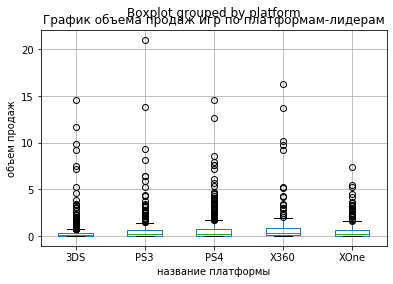

In [64]:
top_platform = data.query('platform ==["PS4","PS3","X360","3DS","XOne"] and year_of_release >= 2012')
plt = top_platform.boxplot(column=['total_sales'], by ='platform')
plt.set_title("График объема продаж игр по платформам-лидерам")
plt.set_ylabel('объем продаж')
plt.set_xlabel('название платформы')

Как видно из графика, выводы по данным затруднительны из-за выбросов в данных (так называемых игр-одиночных "историй успеха" платформ), от которых мы избавимся, ограничив объем продаж отметкой 1.5 млн проданных копий.

Text(0.5, 0, 'название платформы')

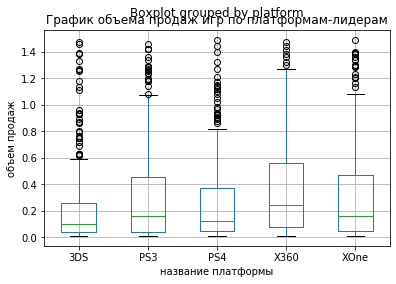

In [65]:
filtered_sales = top_platform.query('total_sales <= 1.5')
plt = filtered_sales.boxplot(column=['total_sales'], by ='platform')
plt.set_title("График объема продаж игр по платформам-лидерам")
plt.set_ylabel('объем продаж')
plt.set_xlabel('название платформы')

Как можно увидеть из графика, наибольшие медианные продажи - у платформ PS3 и X360. Наименьшие продажи - у платформы 3DS.

Изучим, как влияют на продажи внутри платформы PS3 отзывы пользователей и критиков.

In [17]:
sales_scores = actual_platform.query('platform =="PS3"') 
sales_ratings_PS3 = sales_scores.loc[:,['total_sales', 'critic_score', 'user_score']]
sales_ratings_PS3.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.331497,-0.005144
critic_score,0.331497,1.000000,0.539456
user_score,-0.005144,0.539456,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7facf9772750>,
      dtype=object)

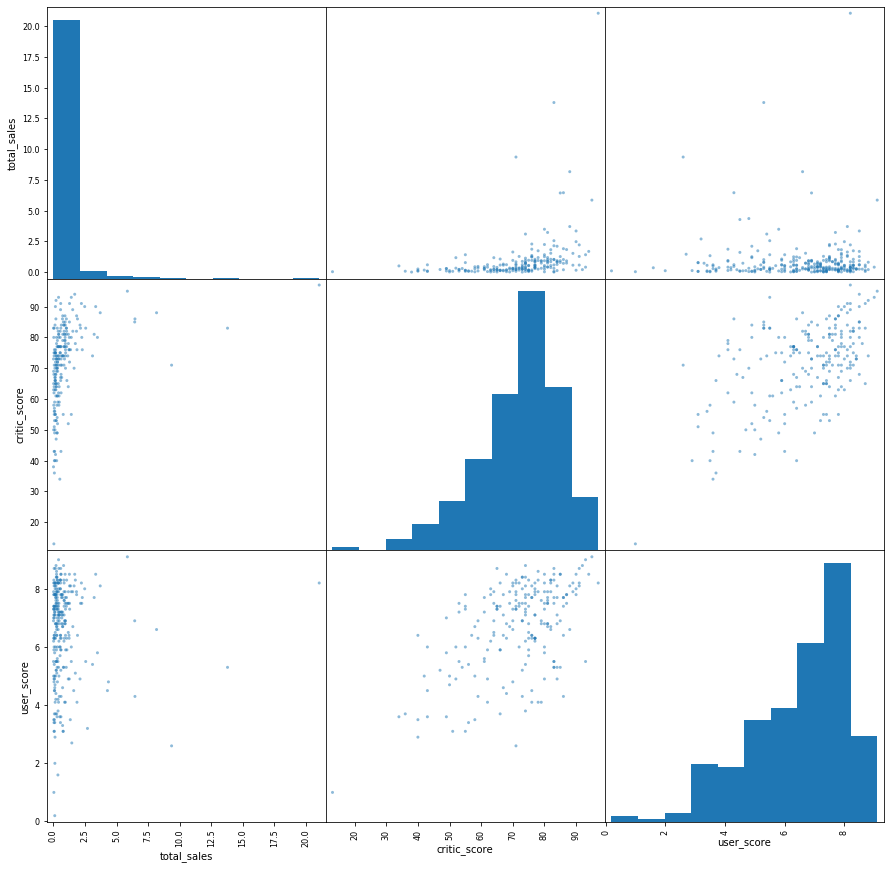

In [18]:
pd.plotting.scatter_matrix(sales_ratings_PS3, figsize=(15, 15))

Таблица сопряженности показывает нам, что связь между продажами и отзывами критиков - слабая положительная, а между продажами и отзывами пользователей связь практически полностью отсутствует.

Изучим, как влияют на продажи внутри платформы X360 отзывы пользователей и критиков.

In [67]:
sales_scores_X360 = actual_platform.query('platform =="X360"') 
sales_ratings_X360 = sales_scores_X360.loc[:,['total_sales', 'critic_score', 'user_score']]
sales_ratings_X360.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.360573,0.006164
critic_score,0.360573,1.000000,0.557352
user_score,0.006164,0.557352,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94c8fa3f90>,
      dtype=object)

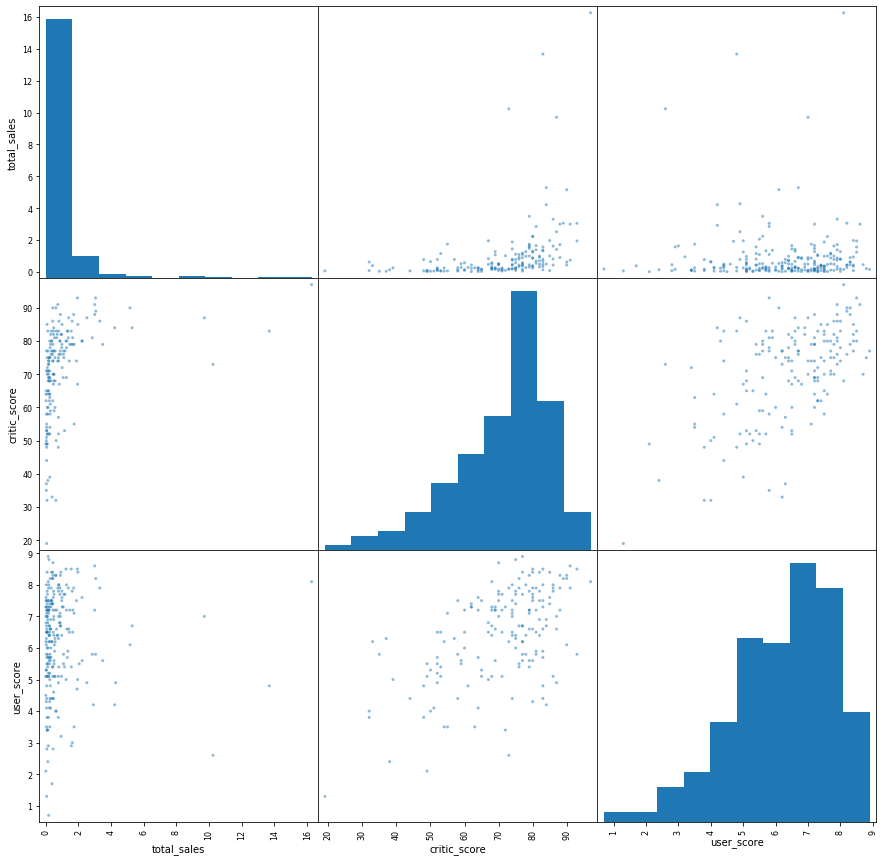

In [68]:
pd.plotting.scatter_matrix(sales_ratings_X360, figsize=(15, 15))

 Таблица сопряженности показывает нам, что связь между продажами и отзывами критиков - слабая положительная, между продажами и отзывами пользователей линейная связь практически отсутсвует.

Изучим, как влияют на продажи внутри платформы 3DS отзывы пользователей и критиков.

In [21]:
sales_scores_3DS = actual_platform.query('platform =="3DS"') 
sales_ratings_3DS = sales_scores_3DS.loc[:,['total_sales', 'critic_score', 'user_score']]
sales_ratings_3DS.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.320803,0.197583
critic_score,0.320803,1.000000,0.722762
user_score,0.197583,0.722762,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7facf362a210>,
      dtype=object)

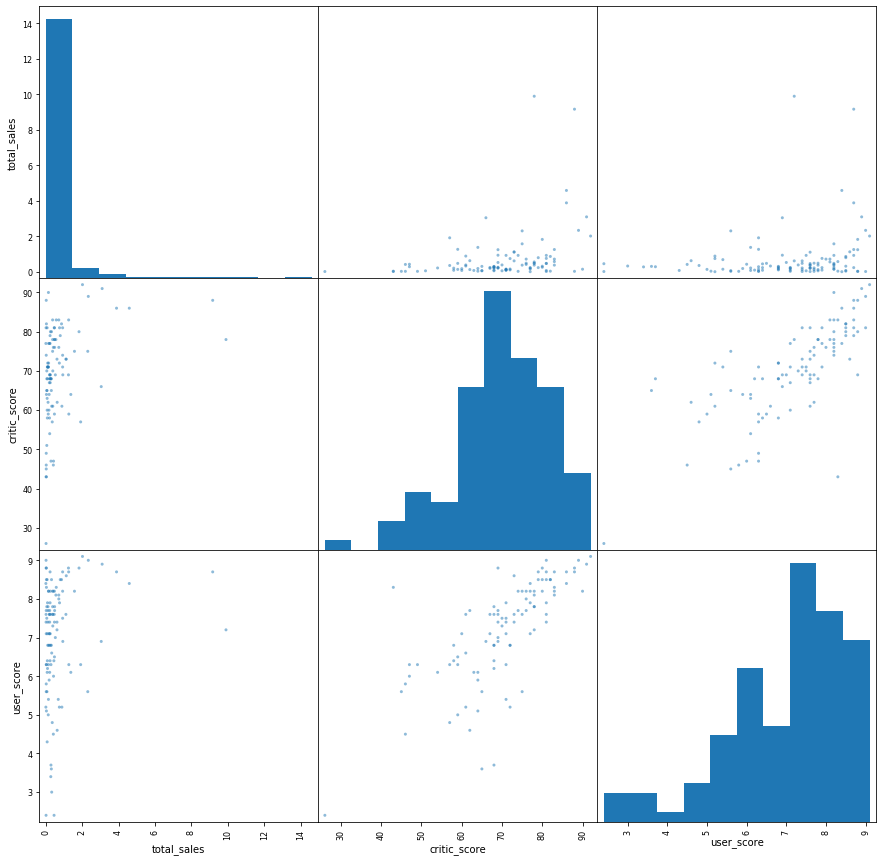

In [22]:
pd.plotting.scatter_matrix(sales_ratings_3DS, figsize=(15, 15))

Таблица сопряженности показывает нам, что связь между продажами и отзывами критиков (а также пользователей) - слабая положительная.

Изучим, как влияют на продажи внутри платформы PS4 отзывы пользователей и критиков.

In [69]:
sales_scores_PS4 = actual_platform.query('platform =="PS4"') 
sales_ratings_PS4 = sales_scores_PS4.loc[:,['total_sales', 'critic_score', 'user_score']]
sales_ratings_PS4.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7facf2f2fbd0>,
      dtype=object)

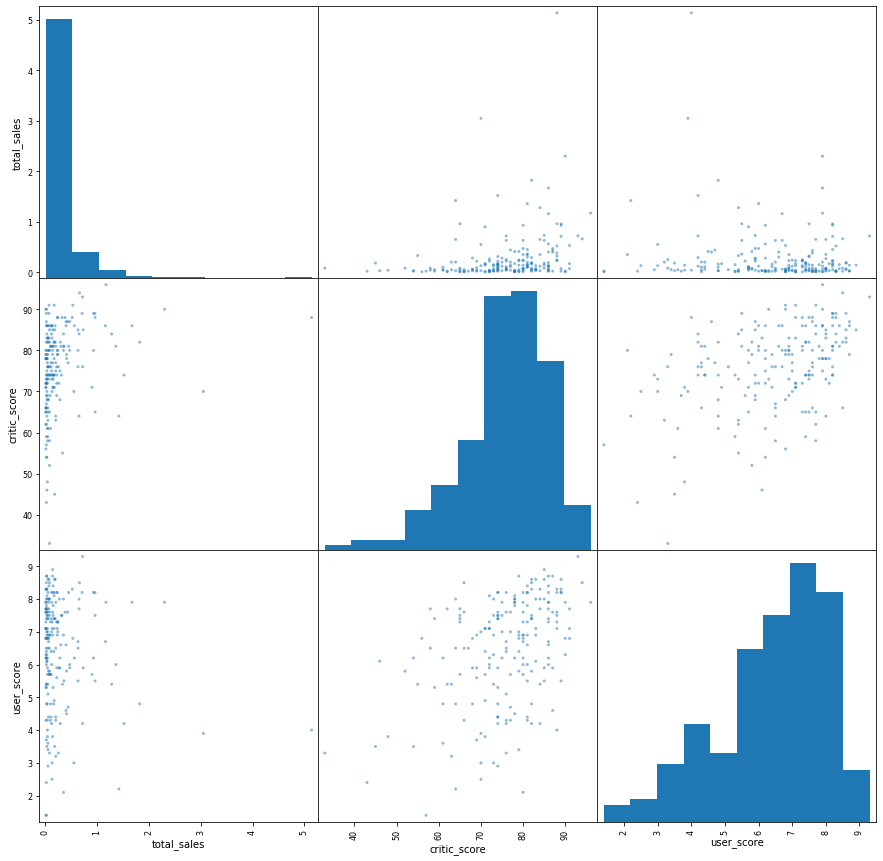

In [24]:
pd.plotting.scatter_matrix(sales_ratings_PS4, figsize=(15, 15))

Таблица сопряженности показывает нам, что связь между продажами и отзывами критиков - слабая положительная, а между продажами и пользоателями она практически отсутствует.

Изучим, как влияют на продажи внутри платформы XOne отзывы пользователей и критиков.

In [70]:
sales_scores_XOne = actual_platform.query('platform =="XOne"') 
sales_ratings_XOne = sales_scores_XOne.loc[:,['total_sales', 'critic_score', 'user_score']]
sales_ratings_XOne.corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.416998,-0.068925
critic_score,0.416998,1.000000,0.472462
user_score,-0.068925,0.472462,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f94c871fbd0>,
      dtype=object)

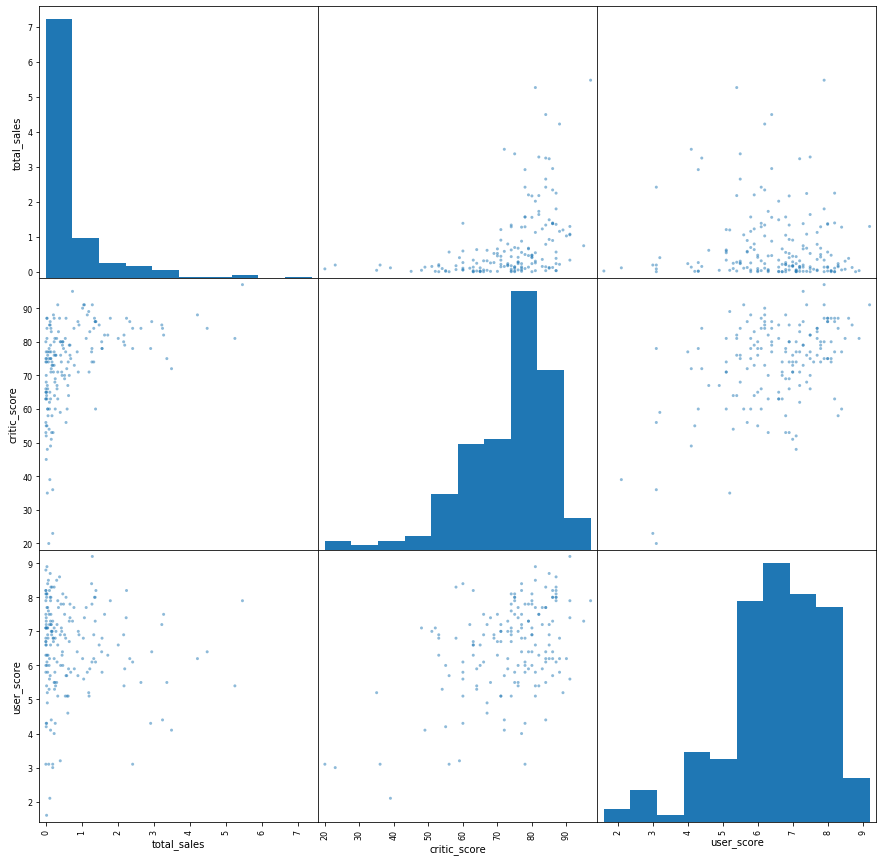

In [72]:
pd.plotting.scatter_matrix(sales_ratings_XOne, figsize=(15, 15))

Таблица сопряженности показывает нам, что связь между продажами и отзывами критиков слабая положительная, а между продажами и оценкой пользователей практически полностью отсутсвует.

Изучим общее распределение игр по жанрам за актуальный период.

In [73]:
actual = data.query('year_of_release >= 2012')
data_genres = actual.pivot_table(index ='genre', values = 'total_sales', aggfunc = 'sum').sort_values(by = 'total_sales', ascending = False).reset_index()
data_genres

,genre,total_sales
0,Action,441.12
1,Shooter,304.73
2,Role-Playing,192.80
3,Sports,181.07
4,Misc,85.04
5,Platform,61.00
6,Racing,53.50
7,Fighting,44.49
8,Simulation,35.12
9,Adventure,29.43


Text(0.5, 0, 'жанр игры')

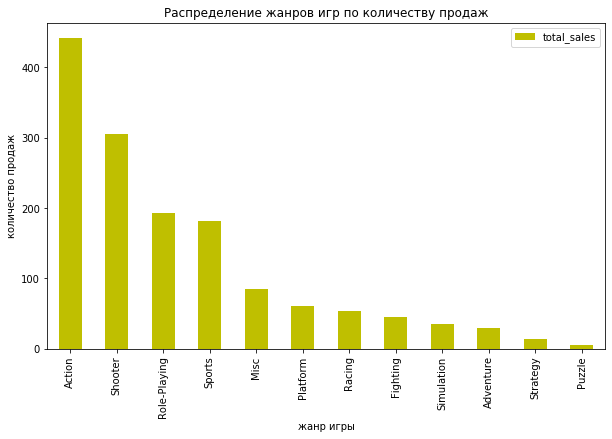

In [74]:
plt = data_genres.plot(y = 'total_sales', x ='genre', kind = 'bar', figsize = (10,6), color = 'y')
plt.set_title("Распределение жанров игр по количеству продаж")
plt.set_ylabel('количество продаж')
plt.set_xlabel('жанр игры')

Среди самых прибыльных жанров можно отметить action, shooter и role-playing, среди наименее прибыльных - adventure, strategy, puzzle. Тем не менее, можно предположить, что игры некоторых жанров столь продаваемы только за счет большего количества игр и большого количества бестселлеров - проверим это, проанализировав медианные продажи игр по жанрам.

In [47]:
data_genres_median = actual.pivot_table(index ='genre', values = 'total_sales', aggfunc = 'median').sort_values(by = 'total_sales', ascending = False).reset_index()
data_genres_median

,genre,total_sales
0,Shooter,0.440
1,Sports,0.240
2,Platform,0.210
3,Role-Playing,0.140
4,Racing,0.140
5,Fighting,0.130
6,Action,0.120
7,Misc,0.120
8,Simulation,0.120
9,Strategy,0.080


Text(0.5, 0, 'жанр игры')

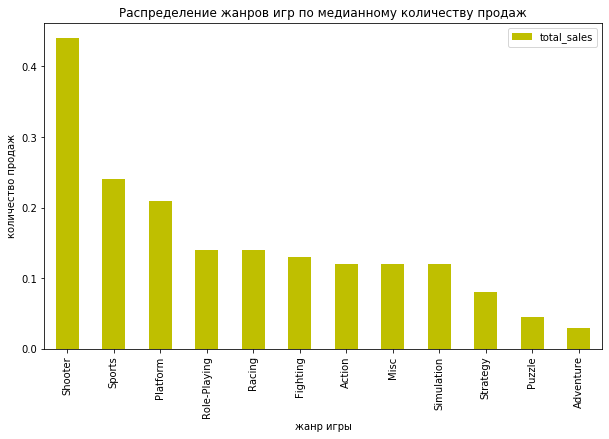

In [49]:
plt = data_genres_median.plot(y = 'total_sales', x ='genre', kind = 'bar', figsize = (10,6), color = 'y')
plt.set_title("Распределение жанров игр по медианному количеству продаж")
plt.set_ylabel('количество продаж')
plt.set_xlabel('жанр игры')

Как видно из графика, медианные продажи несколько изменили жанровое распределение: среди самых продаваемых жанров - shooter, sports и platform,  в то время как лидер нашего прошлого рейтинга - action далеко не в топе, соответственно, наше предположение подтвердилось.

### Вывод

По итогам исследовательского анализа данных можно сделать следующие выводы: 
1. индустрия компьютерных игр начала особенно бурно расти с 2000-х г.,но к 2016 г. наблюдается спад в развитии, который может быть связан с общей тенденцией к более здоровму образу жизни и смене способов отдыха;
2. наиболее прибыльные платформы, обеспечивающие продажи компьютерных игр -  PS4, PS3, X360, 3DS и XOne;
3. наиболее популярные жанры компьютерных игр - шутеры, спортивные соревнования и "ролевые" игры, что связано с общей спецификой компьтерных игр - делая выбор в пользу паралелльной, человек, как правило, стремится уйти в другой мир (примерить на себя другую жизнь) или выплеснуть агрессию на существующий мир;
4. на продажи компьютерных игр отзывы зрителей и критиков практически не влияют.

Перейдем к анализу портрета "потребителя" изучаемого продукта.

## Составление протрета пользователя каждого региона

In [75]:
actual = data.query('year_of_release >= 2012')
na_sales = actual.pivot_table(index = 'platform', values ='na_sales', aggfunc = 'sum').sort_values(by= 'na_sales', ascending = False)
na_sales['percent'] = na_sales['na_sales']/(sum(na_sales['na_sales']))*100
na_sales.head(5)

,na_sales,percent
platform,,
X360,140.05,23.698326
PS4,108.74,18.400257
PS3,103.38,17.493274
XOne,93.12,15.757145
3DS,55.31,9.359189


In [76]:
eu_sales = actual.pivot_table(index = 'platform', values ='eu_sales', aggfunc = 'sum').sort_values(by= 'eu_sales', ascending = False)
eu_sales['percent'] = eu_sales['eu_sales']/(sum(eu_sales['eu_sales']))*100
eu_sales.head(5)

,eu_sales,percent
platform,,
PS4,141.09,27.838286
PS3,106.86,21.084409
X360,74.52,14.703445
XOne,51.59,10.179156
3DS,42.64,8.413243


In [77]:
jp_sales = actual.pivot_table(index = 'platform', values ='jp_sales', aggfunc = 'sum').sort_values(by= 'jp_sales', ascending = False)
jp_sales['percent'] = jp_sales['jp_sales']/(sum(jp_sales['jp_sales']))*100
jp_sales.head(5)

,jp_sales,percent
platform,,
3DS,87.79,45.586250
PS3,35.29,18.324852
PSV,21.04,10.925330
PS4,15.96,8.287465
WiiU,13.01,6.755634


Соответственно, среди лидеров-платформ европейского и американского рынка - X360, PS4 и PS3, в то время как японского - 3DS, PS3 и PSV. Можно отметить, что японцы предпочитают портативные консоли и игры, созданные на родном рынке.

In [32]:
genres_na = actual.pivot_table(index = 'genre', values = 'na_sales', aggfunc = 'sum')
genres_na.sort_values(by = 'na_sales', ascending = False).head(5)  

,na_sales
genre,
Action,177.84
Shooter,144.77
Sports,81.53
Role-Playing,64.00
Misc,38.19


In [33]:
genres_eu = actual.pivot_table(index = 'genre', values = 'eu_sales', aggfunc = 'sum')
genres_eu.sort_values(by = 'eu_sales', ascending = False).head(5)  

,eu_sales
genre,
Action,159.34
Shooter,113.47
Sports,69.09
Role-Playing,48.53
Racing,27.29


In [34]:
genres_jp = actual.pivot_table(index = 'genre', values = 'jp_sales', aggfunc = 'sum')
genres_jp.sort_values(by = 'jp_sales', ascending = False).head(5)  

,jp_sales
genre,
Role-Playing,65.44
Action,52.80
Misc,12.86
Simulation,10.41
Fighting,9.44


Среди популярных жанров европейского и американского рынков - action, shooter  и sports, в то время как пользователи японского рынка предпочитают role-playing, action, misc. Среди возможных объяснений- не только особая культура страны (ее долгая изолированность от внешнего мира и внимание к культурным традициям), но и общее стремление страны к миру и гармонии (поэтому игры-"агрессии", например, шутеры не так популярны на рынке страны).

In [39]:
actual["rating"] = actual["rating"].fillna("Unknown") 
actual["rating"].value_counts()

Unknown    1275
M           498
T           412
E           395
E10+        306
Name: rating, dtype: int64

In [40]:
rating_na = actual.pivot_table(index = 'rating', values = 'na_sales', aggfunc = 'sum')
rating_na.sort_values(by = 'na_sales', ascending = False).head(5)  

,na_sales
rating,
M,231.57
E,114.37
Unknown,103.31
E10+,75.70
T,66.02


In [41]:
rating_eu = actual.pivot_table(index = 'rating', values = 'eu_sales', aggfunc = 'sum')
rating_eu.sort_values(by = 'eu_sales', ascending = False).head(5)  

,eu_sales
rating,
M,193.96
E,113.03
Unknown,91.50
E10+,55.37
T,52.96


In [42]:
rating_jp = actual.pivot_table(index = 'rating', values = 'jp_sales', aggfunc = 'sum')
rating_jp.sort_values(by = 'jp_sales', ascending = False).head(5)  

,jp_sales
rating,
Unknown,108.84
E,28.33
T,26.02
M,21.20
E10+,8.19


Среди наиболее продаваемых по рейтингу игр на американском и европейском рынках - игры рейтинга "М", то есть от 17 лет, в то время как на рынке Японии - рейтинг 'E'("для любого возраста"), что также подчеркивает приоритет "добрых" игр в стране. Игры с отсутсвующим возрастным рейтингом не столь популярны на  американском и европейском рынках, но занимают первое место на японском рынке.

### Вывод

Среди особенностей портрета аудитории американского, европейского и японского рынков - ориентация первых двух на условную "битву" (так или иначе мы говорим о противопоставлении "мой герой-мир" в играх жанра экшн, "стрелялки" и "спорт), а третьего - на условный "мир" (ира как еще один способ гармонии).

## Проверка исследовательских гипотез

Заключительным этапом работы будет проверка двух статистических гипотез с помощью метода scipy.stats.ttest_ind(), позволяющем проверить гипотезу о равенстве среднего двух
генеральных совокупностей по взятым из них выборкам:

 1. средние пользовательские рейтинги платформ Xbox One и PC одинаковы;
 2. средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.

Для проверки гипотез установим уровень значимости равным 0.01. 

В первую очередь сформулируем нулевую и альтернативную гипотезу для проверки первого утверждения:
1. гипотеза H₀ будет состоять в том, что средние пользовательские рейтинги платформ Xbox One и PC  не различаются;
2. гипотеза H₁ будет сформулирована так: средние пользовательские рейтинги платформ Xbox One и PC различаются.

In [38]:
alpha = 0.01
xbox = actual.loc[actual.loc[:,'platform'] == 'XOne']['user_score'].dropna()
pc = actual.loc[actual.loc[:,'platform'] == 'PC']['user_score'].dropna()

In [39]:
results = st.ttest_ind(xbox, pc)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5535080500643661
Не получилось отвергнуть нулевую гипотезу


Можно сделать вывод о том, что средние пользовательские рейтинги платформ не различаются.

Ссформулируем нулевую и альтернативную гипотезу для проверки второго утверждения:
 1. гипотеза H₀ будет состоять в том, что средние пользовательские рейтинги жанров Action  и Sports  одинаковые; 
 2. гипотеза H₁ будет сформулирована так: средние пользовательские рейтинги жанров Action  и Sports разные.

In [40]:
alpha = 0.01
action = actual.loc[actual.loc[:,'genre'] == 'Action']['user_score'].dropna()
sports = actual.loc[actual.loc[:,'genre'] == 'Sports']['user_score'].dropna()

In [41]:
results = st.ttest_ind(action, sports)
print('p-значение:', results.pvalue)
if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 3.7163089460934874e-26
Отвергаем нулевую гипотезу


Можно сделать вывод о том, что средние пользовательские рейтинги жанров Action  и Sports разные.

## Вывод

Таким образом, в результате анализа данных можно сделать следующие выводы:
1. жизненный цикл в 10 лет обусловлен быстрым развитием информационных технологий, сответственно, преимущество получают те платформы, которые адаптируются к этим изменениям или накопили достаточное количество лояльных пользователей;
2. лучше всего продавать игры для таких приставок как Sony Playstation 3 (и PS4), исходя из лидеров продаж, которые мы определили как PS4, PS3, X360, 3DS и XOne;
3. при этом, рассматривая региональную специфику, можно сказать следующее:
   
   3.1 пользователи американского рынка предпочитают среди консолей X360, PS4 и PS3, их жанровые предпочтения - Action, Shooter и Sports, также они предпочитают игры с рейтингом "от 17 и выше":
   
   3.2 пользователи европейского рынка выбирают PS4, PS3 и X360 для  игр жанра Action, Shooter и Sports, отдавая предпочтение играм рейтинга "от 17 и выше";
   
   3.3 в топе пользователей японского рынка консоли 3DS, PS3, PSV и жанры Role-playing, Action, Misc. Они предпочитают игры без рейтинга или те, которые подходят для любого возраста.